## Neural Network Pruning using Quality and Diversity of Neurons 

In this project, I wish to implement a novel neural network pruning algorithm that I developed for my Bachelor's Thesis Project. Pruning is an idea that has been around since the 1990s. Recently, researchers at MIT have proved that such subnetworks exist by pruning specific weights in the network (Lottery Ticket Hypothesis, Frankle et al.). However, this approach has limited practical implications because while performing algebraic calculations via GPUs, the matrix being fed would still be roughly of the same size, despite being sparse. We propose to improvise on this idea and drop entire neurons instead. Hence, the matrix would now be condensed for optimisation. To achieve this, we are using a trained neural network, applying DPP (Determinantal Point Process) on each layer, and then comparing accuracies. To further improve upon accuracies, we are retraining our sparse network as the now optimised calculations would make this step less time-consuming.

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler

from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional, cast
from torch import Tensor
from collections import OrderedDict 
import matplotlib.pyplot as plt

from dppy.finite_dpps import FiniteDPP

We use the FMNIST Dataset. The reason for this was upon research, we found the MNIST dataset to be too 'easy' with even standard neural networks achieving north of 90% accuracy. 

FMNIST is Fashion-MNIST dataset, and much like MNIST, it has 60000 training samples of a 28*28 pixel image of a clothing apparel, and 10 columns to classify it into like T-Shirts, Sneakers, Trousers, etc. 

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values
                          
#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)



trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0,drop_last=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)

## Initialising Model

The architecture is rather simple, a multilayer perceptron, with the input layer as 784 neurons, to flatten the 28*28 pixels, 300 neurons and 100 neurons in the hidden layer, and 10 output labels. It is similar to the architecture used by the MIT researchers hence making comparision extremely straightforward.

We have a batch size of 32, the ReLU activation function after each hidden layer, negative log likelihood loss function, we train till 50 epochs and with a learning rate of 0.0003


In [3]:
from ctypes.wintypes import LPWIN32_FIND_DATAA


class FeedForwardNet(nn.Module): 
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 300)
    self.r1 = nn.ReLU()
    self.fc2 = nn.Linear(300, 100)
    self.r2 = nn.ReLU()
    self.fc3 = nn.Linear(100,10)


  def forward(self,x):
    
    
    x = x.view(x.shape[0],-1)
    x = self.fc1(x)
    x = self.r1(x)
    
    x = self.fc2(x)
    x = self.r2(x)
    
    x = self.fc3(x)
   
    x = F.log_softmax(x, dim=1)
    
    return x

In [4]:
def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        prediction = model(input)
        
        
        loss = loss_fn(prediction, target)

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")
    return loss.item()



def train(model, data_loader, loss_fn, optimiser, device, epochs):
    l = []
    for i in range(epochs):
        print(f"Epoch {i+1}")
        a = train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        l.append(a)
        print("---------------------------")
    print("Finished training")
    return l

## Training

In [5]:
# construct model and assign it to device

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")
feed_forward_net = FeedForwardNet().to(device)
print(feed_forward_net)

# initialise loss funtion + optimiser


loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(feed_forward_net.parameters(),lr=0.0003, weight_decay=1e-4)

# train model
b = train(feed_forward_net, trainloader, loss_fn, optimizer, device, 50)




# save model
torch.save(feed_forward_net, "initial_model.pth")
print("Trained feed forward net saved at initial_model")



Using cuda


FeedForwardNet(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (r1): ReLU()
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (r2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Epoch 1
loss: 0.3541325330734253
---------------------------
Epoch 2
loss: 0.15404842793941498
---------------------------
Epoch 3
loss: 0.43442365527153015
---------------------------
Epoch 4
loss: 0.3594697117805481
---------------------------
Epoch 5
loss: 0.16938529908657074
---------------------------
Epoch 6
loss: 0.22037452459335327
---------------------------
Epoch 7
loss: 0.3631834089756012
---------------------------
Epoch 8
loss: 0.23787429928779602
---------------------------
Epoch 9
loss: 0.10623182356357574
---------------------------
Epoch 10
loss: 0.4968845844268799
---------------------------
Epoch 11
loss: 0.31233450770378113
---------------------------
Epoch 12
loss: 0.2851853370666504
---------------------------
Epoch 13
loss: 0.15003351

## Plotting loss vs epoch for initial model

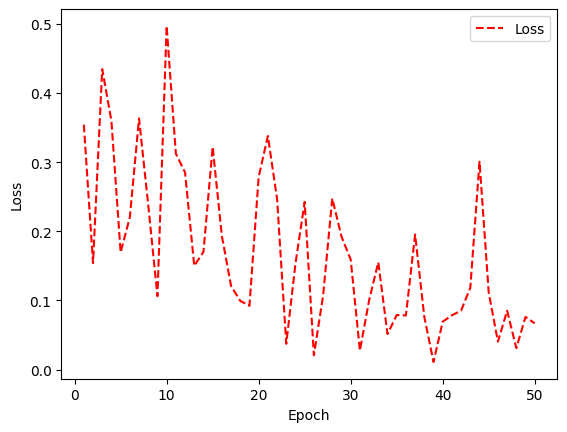

In [6]:
count = range(1, len(b) + 1)
plt.plot(count, b, 'r--')
plt.legend(['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Testing 

In [7]:
def is_gpu():
    return torch.cuda.is_available()

    
test_loss = 0.0
correct, total = 0,0


for data,label in testloader:
    if is_gpu:
        data, label = data.cuda(), label.cuda()
    output = feed_forward_net(data)
    for o,l in zip(torch.argmax(output,axis = 1),label):
        if o == l:
            correct += 1
        total += 1
    loss = loss_fn(output,label)
    
    test_loss += loss.item() * data.size(0)
    
print(f'Testing Loss:{test_loss/len(testloader)}')
print(f'Correct Predictions: {correct}/{total}')

Testing Loss:14.02001743324292
Correct Predictions: 8897/9984


## Storing Weights

In [8]:
# Create empty lists to store the predictions and features
PREDS = []
FEATS1 = []
FEATS2 = []

# loop through batches
for inputs, targets in trainloader:

    # move to device
    inputs = inputs.to(device)
       
    # forward pass
    preds = feed_forward_net(inputs)
    feats1 = feed_forward_net.r1(feed_forward_net.fc1(inputs.view(inputs.shape[0], -1))).detach()
    feats2 = feed_forward_net.r2(feed_forward_net.fc2(feats1)).detach()
    
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS1.append(feats1.cpu().numpy())
    FEATS2.append(feats2.cpu().numpy())

# concatenate the lists of predictions and features
PREDS = np.concatenate(PREDS)
FEATS1 = np.concatenate(FEATS1)
FEATS2 = np.concatenate(FEATS2)

print('- preds shape:', PREDS.shape)
print('- feats1 shape:', FEATS1.shape)
print('- feats2 shape:', FEATS2.shape)

a = PREDS
a11 = FEATS1
a22 = FEATS2

av_layer1 = a11.mean(0)
av_layer2 = a22.mean(0)

- preds shape: (60000, 10)
- feats1 shape: (60000, 300)
- feats2 shape: (60000, 100)


## Determinantal Point Process (DPP)

Determinental Point Process, or DPP, is an algorithm that was proposed by Alex Kulesza and Ben Taskar in 2012. Here, we create a K by K kernel matrix L where $L[i][j] = f(a_i, a_j)$, here $a_i$ and $a_j$ would represent the ith and jth neuron for us. 

What we want to do is choose a submatrix, such that $p(y) = det(L_y)/det(L+I)$, $I$ being an Identity matrix. 

We want to maximise this probability. The word k-dpp simply indicates that we're choosing a subsection of length k. 

To maximise $p(y)$, we would want to maximise $det(L_y)$. This implies Meaning higher activation values of neurons would be promoted, but pairs of neurons having similarly high values would be penalised. 


## Creating DPP Kernel

We develop a kernel for each of our hidden layers, two in our case. 

The kernel L is a matrix of size n by n, where n is the number of neurons in that layer. 

The values of L follow this formula, where q is the quality, which is the average activation value of that neuron, when averaged over the 60,000 training samples. 

$C_(ij)$ is correlation between two vectors of 60,000 length of activation values of neurons $i$ and $j$. We use the Pearson Correlation Coefficient:

$$ (1/n)*  \Sigma (x_i - av(x)) . (y_i - av(y)) $$

Where $av(x)$ is the average value of x


In [9]:
#specify extent to prune

z = 0.75

kernel1 = np.zeros((300,300))
from scipy.stats.stats import pearsonr  
def corr_coeff(k,m):
      
    var1 = np.transpose(a11)[k]
    var2 = np.transpose(a11)[m]
    if np.isnan(pearsonr(var1,var2)[0]):
        return 0
    else:
        return pearsonr(var1,var2)[0]

from tqdm import tqdm


pbar = tqdm(total=kernel1.shape[0])
for i in range(0,kernel1.shape[0]):
    for j in range(0,kernel1.shape[1]):
        kernel1[i][j] = av_layer1[i]*av_layer1[j]*corr_coeff(i,j)
    pbar.update(1)

DPP = FiniteDPP('likelihood', **{'L': kernel1})
dd1=DPP.sample_exact_k_dpp(size=int((1-z)*300))



kernel2 = np.zeros((100,100))
from scipy.stats.stats import pearsonr  
def corr_coeff_2(k,m):
      
    var1 = np.transpose(a22)[k]
    var2 = np.transpose(a22)[m]
    if np.isnan(pearsonr(var1,var2)[0]):
        return 0
    else:
        return pearsonr(var1,var2)[0]

from tqdm import tqdm
for i in tqdm(range(0,kernel2.shape[0])):
    for j in range(0,kernel2.shape[1]):
        kernel2[i][j] = av_layer2[i]*av_layer2[j]*corr_coeff_2(i,j)

DPP = FiniteDPP('likelihood', **{'L': kernel2})
dd2=DPP.sample_exact_k_dpp(size=int((1-z)*100))   

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20048\3278946252.py:6: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr
  0%|          | 0/300 [00:00<?, ?it/s]c:\Users\ASUS\Downloads\lottery ticket paper\fc1\.venv\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 300/300 [04:51<00:00,  1.07s/it]C:\Users\ASUS\AppData\Local\Temp\ipykernel_20048\3278946252.py:31: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


## Pruning

In [10]:
to_prune_1 = list(range(0,300))
to_prune_1 = [ele for ele in to_prune_1 if ele not in dd1]
to_prune_2 = list(range(0,100))
to_prune_2 = [ele for ele in to_prune_2 if ele not in dd2]

d1 = feed_forward_net.fc1.weight.tolist()
d2 = feed_forward_net.fc2.weight.tolist()
dd1 = sorted(dd1)
dd2 = sorted(dd2)

In [16]:
l1 = []
for i in dd1:
    l1.append(d1[i])
tmp1 = torch.Tensor(l1)

for j in range(len(d2)):
    d2[j]  =[elem for i,elem in enumerate(d2[j]) if i in dd1]


l2 = []
for i in dd2:
    l2.append(d2[i])
tmp2 = torch.Tensor(l2)

for i in to_prune_1:
    feed_forward_net.fc1.weight.data[i] = 0
for j in to_prune_2:
    feed_forward_net.fc2.weight.data[j] = 0


## Testing again

In [17]:
test_loss = 0.0
correct, total = 0,0
f_ = []

for data,label in testloader:
    
    if is_gpu:
        data, label = data.cuda(), label.cuda()
    output = feed_forward_net(data)
    for o,l in zip(torch.argmax(output,axis = 1),label):
        if o == l:
            correct += 1
        total += 1
    loss = loss_fn(output,label)
    f_.append(loss)
    test_loss += loss.item() * data.size(0)
print(f'Testing Loss:{test_loss/len(testloader)}')

print(f'Correct Predictions: {correct}/{total}')

Testing Loss:45.529184732681664
Correct Predictions: 4184/9984


## Plotting loss

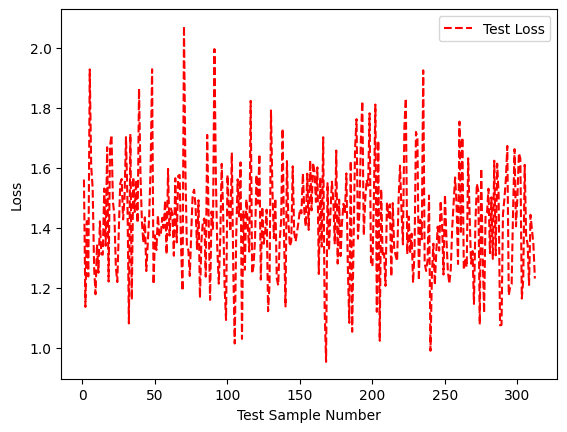

In [23]:
f_cpu = [tensor.cpu().item() for tensor in f_]

count = range(1, len(f_cpu) + 1)

# Plot the data
plt.plot(count, f_cpu, 'r--')
plt.legend(['Test Loss'])
plt.xlabel('Test Sample Number')
plt.ylabel('Loss')
plt.show()

## Retraining

In [25]:
from ctypes.wintypes import LPWIN32_FIND_DATAA

h1 = int((1-z)*300)
h2 = int((1-z)*100)


class FeedForwardNet(nn.Module): 
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, h1)
    self.r1 = nn.ReLU()
    self.fc2 = nn.Linear(h1,h2)
    self.r2 = nn.ReLU()
    self.fc3 = nn.Linear(h2,10)


  def forward(self,x):
    
    
    x = x.view(x.shape[0],-1)
    x = self.fc1(x)
    x = self.r1(x)
    
    x = self.fc2(x)
    x = self.r2(x)
    
    x = self.fc3(x)
   
    x = F.log_softmax(x, dim=1)
    
    return x
    
  def init_weights(self):
    self.fc1.weight = torch.nn.Parameter(tmp1)
    self.fc2.weight = torch.nn.Parameter(tmp2)



    # construct model and assign it to device

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")
retrained_model = FeedForwardNet().to(device)
print(retrained_model)

# initialise loss funtion + optimiser


loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(retrained_model.parameters(),lr=0.0003, weight_decay=1e-4)

# train model
f = train(retrained_model, trainloader, loss_fn, optimizer, device, 50)


torch.save(retrained_model, "final_model.pth")
print("Trained feed forward net saved at final_model")


Using cuda
FeedForwardNet(
  (fc1): Linear(in_features=784, out_features=75, bias=True)
  (r1): ReLU()
  (fc2): Linear(in_features=75, out_features=25, bias=True)
  (r2): ReLU()
  (fc3): Linear(in_features=25, out_features=10, bias=True)
)
Epoch 1
loss: 0.5694732666015625
---------------------------
Epoch 2
loss: 0.21349120140075684
---------------------------
Epoch 3
loss: 0.472393661737442
---------------------------
Epoch 4
loss: 0.6254552602767944
---------------------------
Epoch 5
loss: 0.19689680635929108
---------------------------
Epoch 6
loss: 0.23839235305786133
---------------------------
Epoch 7
loss: 0.3974384069442749
---------------------------
Epoch 8
loss: 0.18460039794445038
---------------------------
Epoch 9
loss: 0.1664714515209198
---------------------------
Epoch 10
loss: 0.4872082471847534
---------------------------
Epoch 11
loss: 0.18702003359794617
---------------------------
Epoch 12
loss: 0.12255045026540756
---------------------------
Epoch 13
loss: 0.281

## Plotting loss

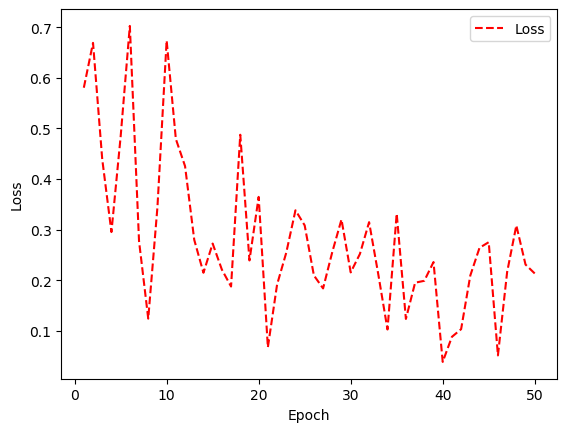

In [ ]:
count = range(1, len(f) + 1)
plt.plot(count, f, 'r--')
plt.legend(['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Testing....again

In [ ]:
test_loss = 0.0
correct, total = 0,0
ff = []
for data,label in testloader:
    if is_gpu:
        data, label = data.cuda(), label.cuda()
    output = modell(data)
    for o,l in zip(torch.argmax(output,axis = 1),label):
        if o == l:
            correct += 1
        total += 1
    loss = loss_fn(output,label)
    ff.append(loss)
    test_loss += loss.item() * data.size(0)
    
print(f'Testing Loss:{test_loss/len(testloader)}')
print(f'Correct Predictions: {correct}/{total}')

Testing Loss:12.175165757536888
Correct Predictions: 8755/9984


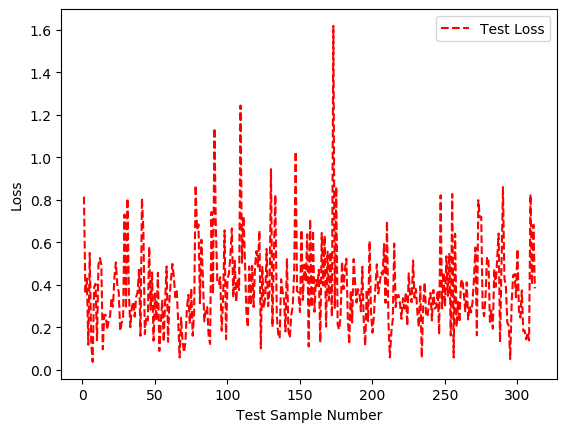

In [ ]:
count = range(1, len(ff) + 1)
plt.plot(count, ff, 'r--')
plt.legend(['Test Loss'])
plt.xlabel('Test Sample Number')
plt.ylabel('Loss')
plt.show();